In [1]:
import numpy as np
from spec_id import Iterative_stacking, Median_w_Error_cont, Median_w_Error, Oldest_galaxy
from vtl.Readfile import Readfile
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage.interpolation import rotate
from astropy.cosmology import Planck13 as cosmo
from astropy.io import ascii, fits
from astropy.table import Table
import grizli
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from astropy.cosmology import Planck13 as cosmo
import astropy.units as u
# import rpy2
# import rpy2.robjects as robjects
# R = robjects.r
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
### set home for files
hpath = os.environ['HOME'] + '/'

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631 and ids != 41148')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [11]:
goodss_rad = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodsn_rad = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()

In [18]:
Reff = []

for i in galDB.index:
    if galDB.gids[i][0] == 's':
        r = goodss_rad.re[goodss_rad.NUMBER == galDB.ids[i]].values * np.sqrt(goodss_rad.q[goodss_rad.NUMBER == galDB.ids[i]].values)
        Reff.append(r[0])
    if galDB.gids[i][0] == 'n':
        r = goodsn_rad.re[goodsn_rad.NUMBER == galDB.ids[i]].values * np.sqrt(goodsn_rad.q[goodsn_rad.NUMBER == galDB.ids[i]].values)
        Reff.append(r[0])
        

# get all quiescent galaxy info

In [7]:
goods_s=Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

if hpath == '/Users/Vince.ec/':
    catpath = hpath
else:
    catpath='/Users/vestrada/Desktop/'

restc_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
restc_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()

fast_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
fast_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()

eazy_s = Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout',
               format = 'ascii').to_pandas()
eazy_n = Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout',
               format = 'ascii').to_pandas()

In [144]:
IDS=[]
IDN=[]

for i in range(len(restc_s['id'])):
    if eazy_s.z_spec[i] != -1:
        rshift = eazy_s.z_spec[i]
    else: 
        rshift = eazy_s.z_peak[i]

    if 1<= rshift <=1.8 and goods_s['class_star'][i]<0.8 and fast_s['lmass'][i] >= 10:
        IDS.append(i)

for i in range(len(restc_n['id'])):
    if eazy_n.z_spec[i] != -1:
        rshift = eazy_n.z_spec[i]
    else: 
        rshift = eazy_n.z_peak[i]

    if 1<= rshift <=1.8 and goods_n['class_star'][i]<0.8 and fast_n['lmass'][i] >= 10:
        IDN.append(i)

In [145]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

uvS=Mag(restc_s['L153'][IDS].values) - Mag(restc_s['L155'][IDS].values)
vjS=Mag(restc_s['L155'][IDS].values) - Mag(restc_s['L161'][IDS].values)
uvN=Mag(restc_n['L153'][IDN].values) - Mag(restc_n['L155'][IDN].values)
vjN=Mag(restc_n['L155'][IDN].values) - Mag(restc_n['L161'][IDN].values)

IDSQ=[]
IDSsf=[]

IDNQ=[]
IDNsf=[]

for i in range(len(uvS)):
    if uvS[i]>=0.88*vjS[i]+0.59 and uvS[i]>1.382 and vjS[i]<1.65:
        IDSQ.append(i)
    if uvS[i]<0.88*vjS[i]+0.59:
        IDSsf.append(i)
        
for i in range(len(uvN)):
    if uvN[i]>=0.88*vjN[i]+0.59 and uvN[i]>1.382 and vjN[i]<1.65:
        IDNQ.append(i)
    if uvN[i]<0.88*vjN[i]+0.59:
        IDNsf.append(i)

No handles with labels found to put in legend.


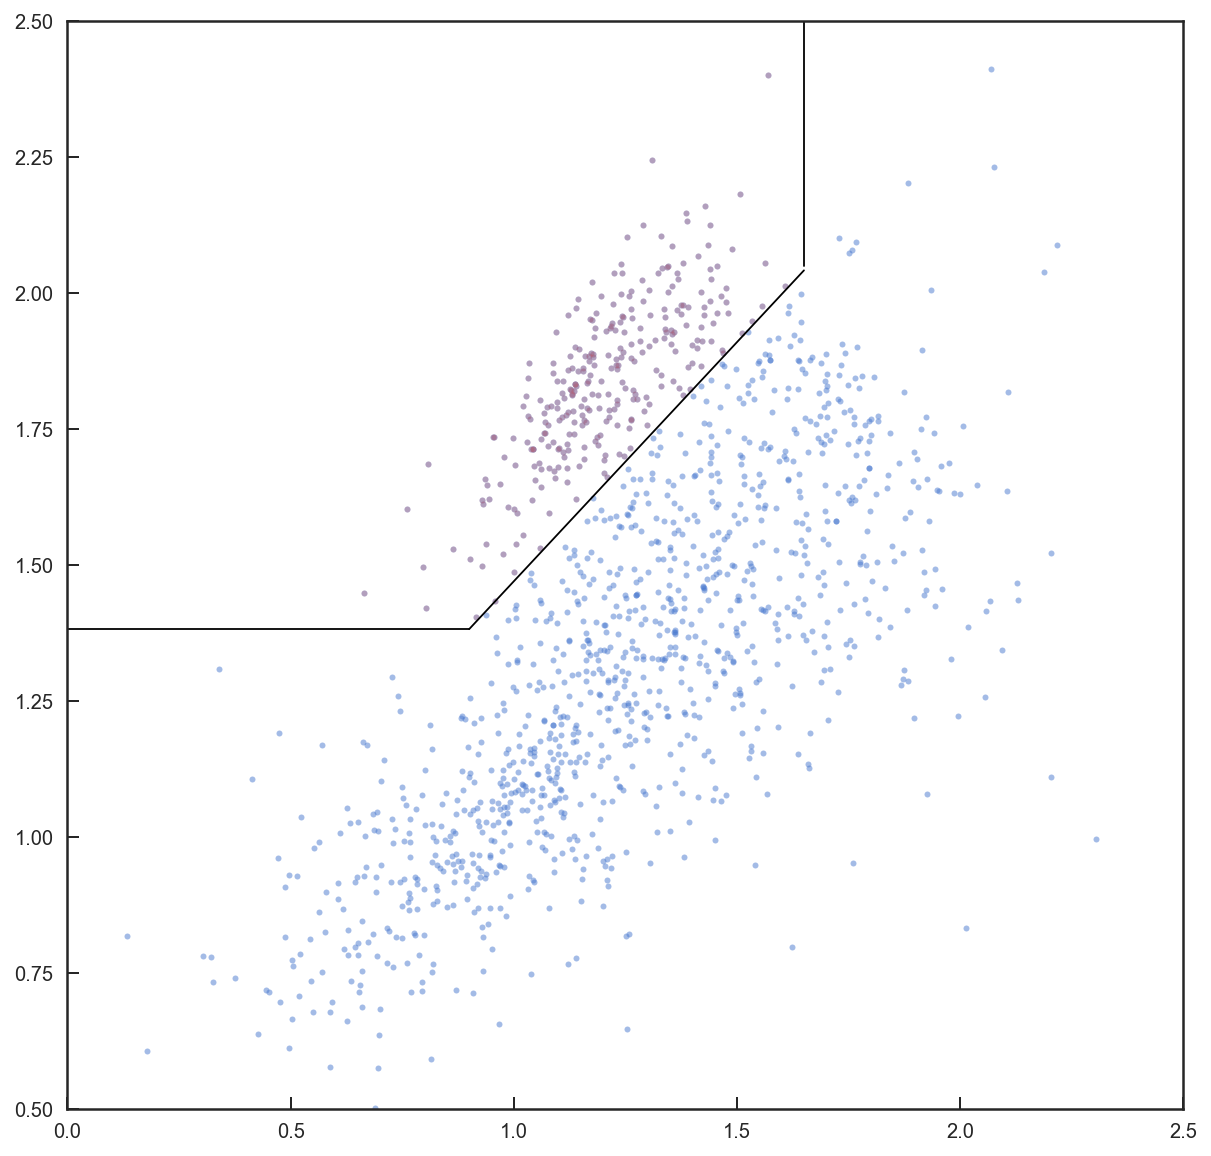

In [146]:
plt.figure(figsize=[10,10])
plt.plot(vjS,uvS,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjN,uvN,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjS[IDSQ],uvS[IDSQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot(vjN[IDNQ],uvN[IDNQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2)
plt.show()
plt.close()

In [147]:
s_all =pd.DataFrame({ 'gids' : eazy_s.id[np.array(IDS)[np.array(IDSQ)]],
    'zspec' : eazy_s.z_spec[np.array(IDS)[np.array(IDSQ)]],
    'zphot' : eazy_s.z_peak[np.array(IDS)[np.array(IDSQ)]],
    'ra' : goods_s.ra[np.array(IDS)[np.array(IDSQ)]],
    'dec' : goods_s.dec[np.array(IDS)[np.array(IDSQ)]],
    'lmass' : fast_s.lmass[np.array(IDS)[np.array(IDSQ)]],
    'lage' : fast_s.lage[np.array(IDS)[np.array(IDSQ)]]
    })

n_all =pd.DataFrame({ 'gids' : eazy_n.id[np.array(IDN)[np.array(IDNQ)]],
    'zspec' : eazy_n.z_spec[np.array(IDN)[np.array(IDNQ)]],
    'zphot' : eazy_n.z_peak[np.array(IDN)[np.array(IDNQ)]],
    'ra' : goods_n.ra[np.array(IDN)[np.array(IDNQ)]],
    'dec' : goods_n.dec[np.array(IDN)[np.array(IDNQ)]],
    'lmass' : fast_n.lmass[np.array(IDN)[np.array(IDNQ)]],
    'lage' : fast_n.lage[np.array(IDN)[np.array(IDNQ)]]
    })

In [148]:
fast_s.keys()

Index(['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr',
       'la2t', 'chi2'],
      dtype='object')

In [149]:
s_Reff = []
n_Reff = []

for i in s_all.index:
    r = goodss_rad.re[i] * np.sqrt(goodss_rad.q[i])
    if s_all.zspec[i] != -1:
        rshift = s_all.zspec[i]
    else: 
        rshift = s_all.zphot[i]
    sizes = cosmo.kpc_proper_per_arcmin(rshift) * r/60 * u.arcmin

    s_Reff.append(sizes.value)
        
for i in n_all.index:
    r = goodsn_rad.re[i] * np.sqrt(goodsn_rad.q[i])
    if n_all.zspec[i] != -1:
        rshift = n_all.zspec[i]
    else: 
        rshift = n_all.zphot[i]
    sizes = cosmo.kpc_proper_per_arcmin(rshift) * r/60 * u.arcmin
    
    n_Reff.append(sizes.value)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [150]:
s_all['reff'] = s_Reff
n_all['reff'] = n_Reff

# Age v mass v morphology plot

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


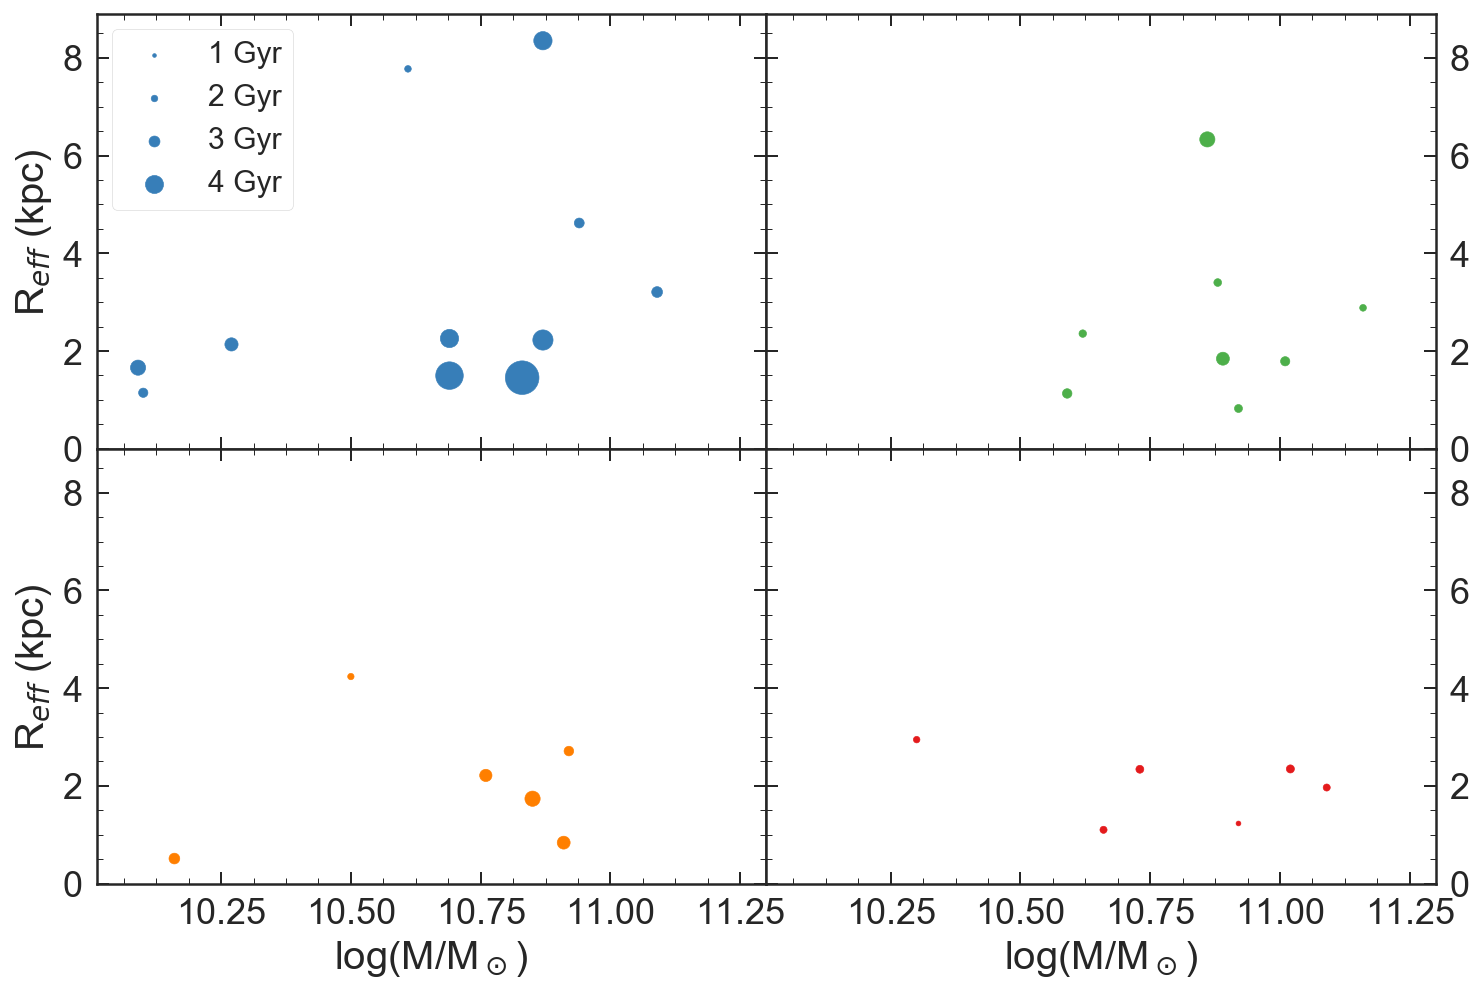

In [90]:
gs= gridspec.GridSpec(2,2,hspace=0,wspace=0)

plt.figure(figsize=[12,8])
sizes = cosmo.kpc_proper_per_arcmin(lzDB['hi_res_specz']) * lzDB['Reff'].values/60 * u.arcmin

plt.subplot(gs[0])
plt.scatter(lzDB['lmass'], sizes,color='#377eb8', s= np.sinh(lzDB['tx_lwa'])*3,marker='o')
plt.scatter(6,6,color='#377eb8',marker='o',s=np.sinh(1)*3,label = '1 Gyr')
plt.scatter(6,6,color='#377eb8',marker='o',s=np.sinh(2)*3,label = '2 Gyr')
plt.scatter(6,6,color='#377eb8',marker='o',s=np.sinh(3)*3,label = '3 Gyr')
plt.scatter(6,6,color='#377eb8',marker='o',s=np.sinh(4)*3,label = '4 Gyr')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.ylabel('R$_{eff}$ (kpc)',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc=2,fontsize=15,frameon=True)
plt.ylim(0,8.9)
plt.xlim(10.01,11.3)
plt.minorticks_on()

sizes = cosmo.kpc_proper_per_arcmin(mzDB['hi_res_specz']) * mzDB['Reff'].values/60 * u.arcmin

plt.subplot(gs[1])
plt.scatter(mzDB['lmass'], sizes,color='#4daf4a', s= np.sinh(mzDB['tx_lwa'])*3,marker='o')
plt.gca().tick_params(axis='y',labelright='on')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelleft='off')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylim(0,8.9)
plt.xlim(10.01,11.3)
plt.minorticks_on()

sizes = cosmo.kpc_proper_per_arcmin(hzDB['hi_res_specz']) * hzDB['Reff'].values/60 * u.arcmin

plt.subplot(gs[2])
plt.scatter(hzDB['lmass'], sizes,color='#ff7f00', s= np.sinh(hzDB['tx_lwa'])*3,marker='o')
plt.xlabel('log(M/M$_\odot$)',fontsize=20)
plt.ylabel('R$_{eff}$ (kpc)',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylim(0,8.9)
plt.xlim(10.01,11.3)
plt.minorticks_on()

sizes = cosmo.kpc_proper_per_arcmin(uhzDB['hi_res_specz']) * uhzDB['Reff'].values/60 * u.arcmin

plt.subplot(gs[3])
plt.scatter(uhzDB['lmass'], sizes,color='#e41a1c', s= np.sinh(uhzDB['tx_lwa'])*3,marker='o')
plt.xlabel('log(M/M$_\odot$)',fontsize=20)
plt.gca().tick_params(axis='y',labelright='on')
plt.gca().tick_params(axis='y',labelleft='off')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylim(0,8.9)
plt.xlim(10.01,11.3)
plt.minorticks_on()
plt.savefig('../plots/reff_lmass.png',bbox_inches = 'tight')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


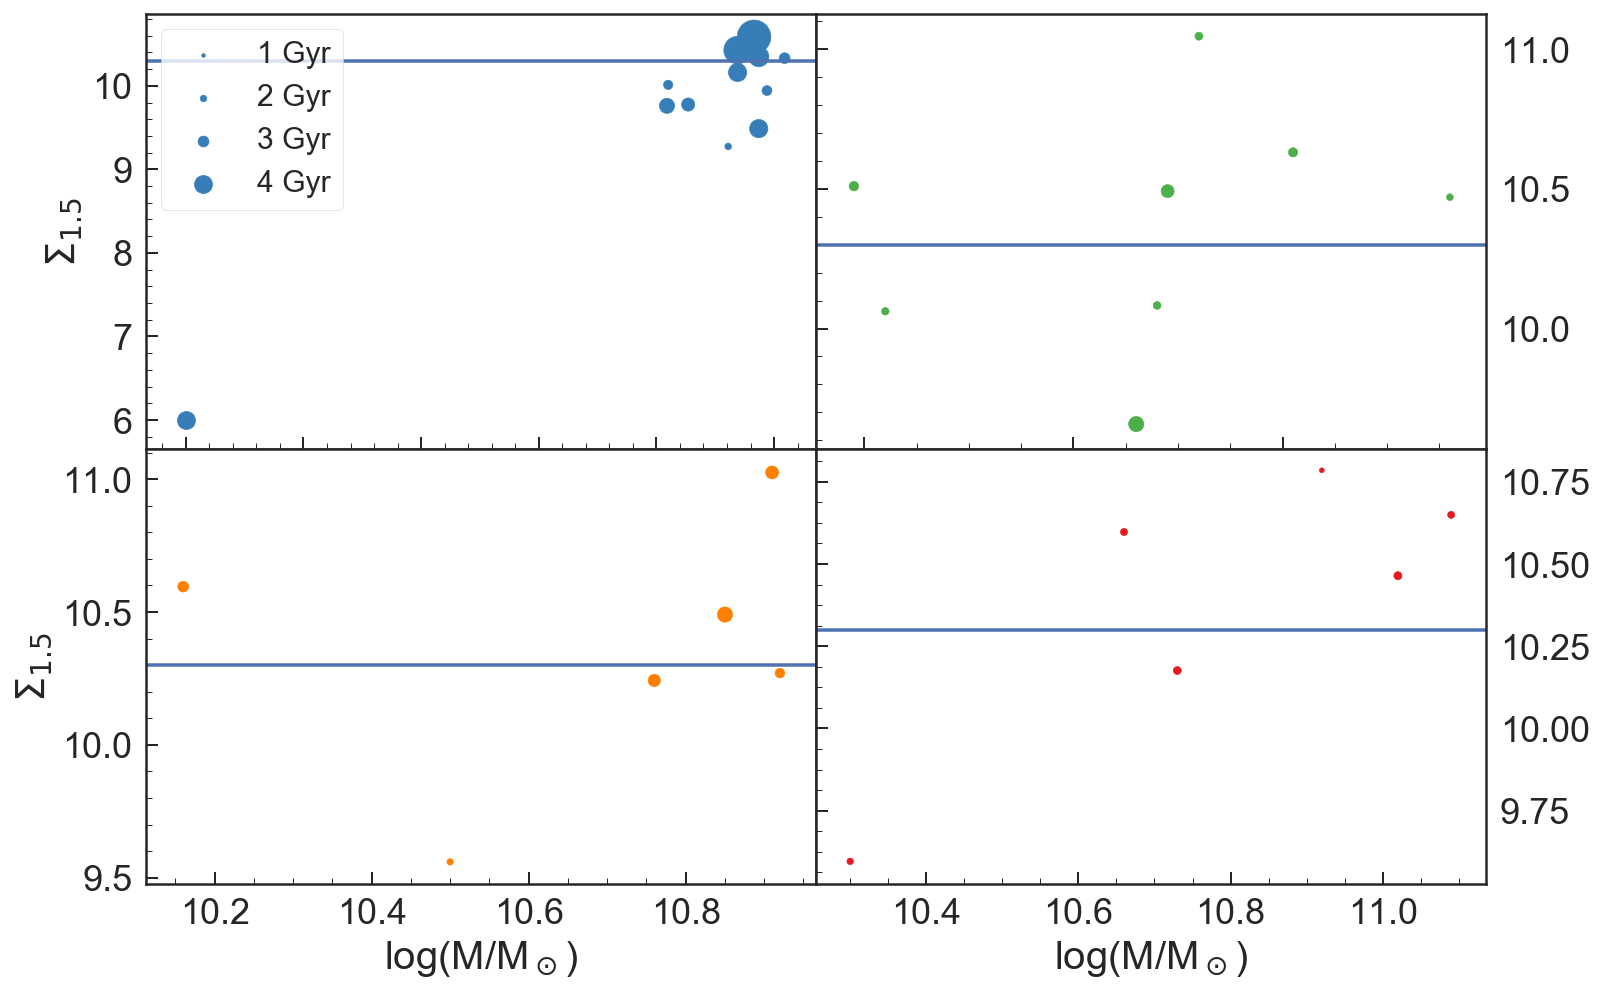

In [217]:
gs= gridspec.GridSpec(2,2,hspace=0,wspace=0)

plt.figure(figsize=[12,8])
sizes = cosmo.kpc_proper_per_arcmin(lzDB['hi_res_specz']) * lzDB['Reff'].values/60 * u.arcmin

plt.subplot(gs[0])
plt.scatter(lzDB['lmass'],np.log10(10**lzDB['lmass'].values/ sizes.value**1.5),color='#377eb8', s= np.sinh(lzDB['tx_lwa'])*3,marker='o')
plt.axhline(10.3)
plt.scatter(6,6,color='#377eb8',marker='o',s=np.sinh(1)*3,label = '1 Gyr')
plt.scatter(6,6,color='#377eb8',marker='o',s=np.sinh(2)*3,label = '2 Gyr')
plt.scatter(6,6,color='#377eb8',marker='o',s=np.sinh(3)*3,label = '3 Gyr')
plt.scatter(6,6,color='#377eb8',marker='o',s=np.sinh(4)*3,label = '4 Gyr')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.ylabel('$\Sigma _ {1.5}$',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc=2,fontsize=15,frameon=True)
# plt.ylim(0,29)
# plt.xlim(10.01,11.3)
plt.minorticks_on()

sizes = cosmo.kpc_proper_per_arcmin(mzDB['hi_res_specz']) * mzDB['Reff'].values/60 * u.arcmin

plt.subplot(gs[1])
plt.scatter(mzDB['lmass'], np.log10(10**mzDB['lmass']/ sizes.value**1.5),color='#4daf4a', s= np.sinh(mzDB['tx_lwa'])*3,marker='o')
plt.axhline(10.3)
plt.gca().tick_params(axis='y',labelright='on')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelleft='off')
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.ylim(0,29)
# plt.xlim(10.01,11.3)
plt.minorticks_on()

sizes = cosmo.kpc_proper_per_arcmin(hzDB['hi_res_specz']) * hzDB['Reff'].values/60 * u.arcmin

plt.subplot(gs[2])
plt.scatter(hzDB['lmass'], np.log10(10**hzDB['lmass']/ sizes.value**1.5),color='#ff7f00', s= np.sinh(hzDB['tx_lwa'])*3,marker='o')
plt.axhline(10.3)

plt.xlabel('log(M/M$_\odot$)',fontsize=20)
plt.ylabel('$\Sigma _ {1.5}$',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.ylim(0,29)
# plt.xlim(10.01,11.3)
plt.minorticks_on()

sizes = cosmo.kpc_proper_per_arcmin(uhzDB['hi_res_specz']) * uhzDB['Reff'].values/60 * u.arcmin

plt.subplot(gs[3])
plt.scatter(uhzDB['lmass'], np.log10(10**uhzDB['lmass']/ sizes.value**1.5),color='#e41a1c', s= np.sinh(uhzDB['tx_lwa'])*3,marker='o')
plt.axhline(10.3)

plt.xlabel('log(M/M$_\odot$)',fontsize=20)
plt.gca().tick_params(axis='y',labelright='on')
plt.gca().tick_params(axis='y',labelleft='off')
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.ylim(0,29)
# plt.xlim(10.01,11.3)
plt.minorticks_on()
# plt.savefig('../plots/sig_lmass.png',bbox_inches = 'tight')


# plot all galaxies

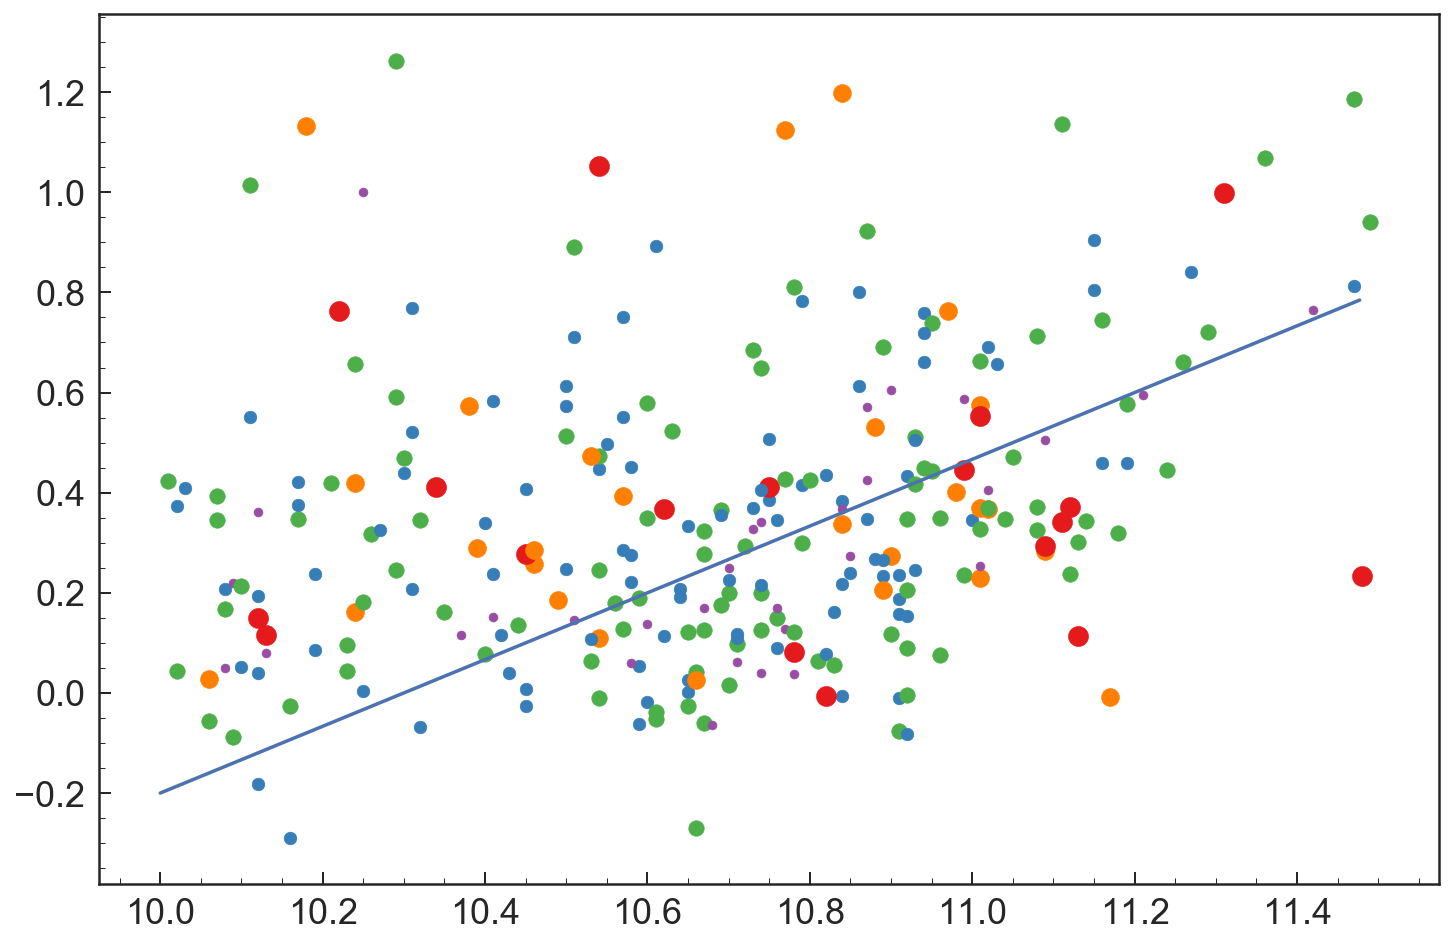

In [209]:
plt.figure(figsize=[12,8])

for i in all_db.index:
    if all_db.zspec[i] != -1:
        rshift = all_db.zspec[i]
    else: 
        rshift = all_db.zphot[i]
    z70 = Oldest_galaxy(rshift)- 10**(all_db.lage[i]-9)
    if z70 > 4:
        c = '#984ea3'
        sz = 20
    if 3 < z70 < 4:
        c = '#377eb8'
        sz = 40
    if 2 < z70 < 3:
        c = '#4daf4a'
        sz = 60
    if 1 < z70 < 2:
        c = '#ff7f00'
        sz = 80
    if 0 < z70 < 1:
        c = '#e41a1c'
        sz = 100
    plt.scatter(all_db['lmass'][i],np.log10(all_db['reff'][i]),color=c, s=sz,marker='o')
#     plt.scatter(rshift,np.log10(all_db['Sig1_5'][i]),color=c, s=sz,marker='o')
#     plt.scatter(rshift,z70,color=c, s=sz,marker='o')

plt.plot(np.log10(np.linspace(1E10,3E11,10000)),np.log10((np.linspace(1E10,3E11,10000)/10**10.3)**(1/1.5)))
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.ylim(0,20)
plt.minorticks_on()

In [172]:
all_db = pd.concat([s_all,n_all])
all_db = all_db.query('reff > 0')
all_db = all_db.query('reff < 20')
all_db['Sig1_5']=10**all_db['lmass']/all_db['reff']**1.5
all_db = all_db.query('Sig1_5 < 2E13')


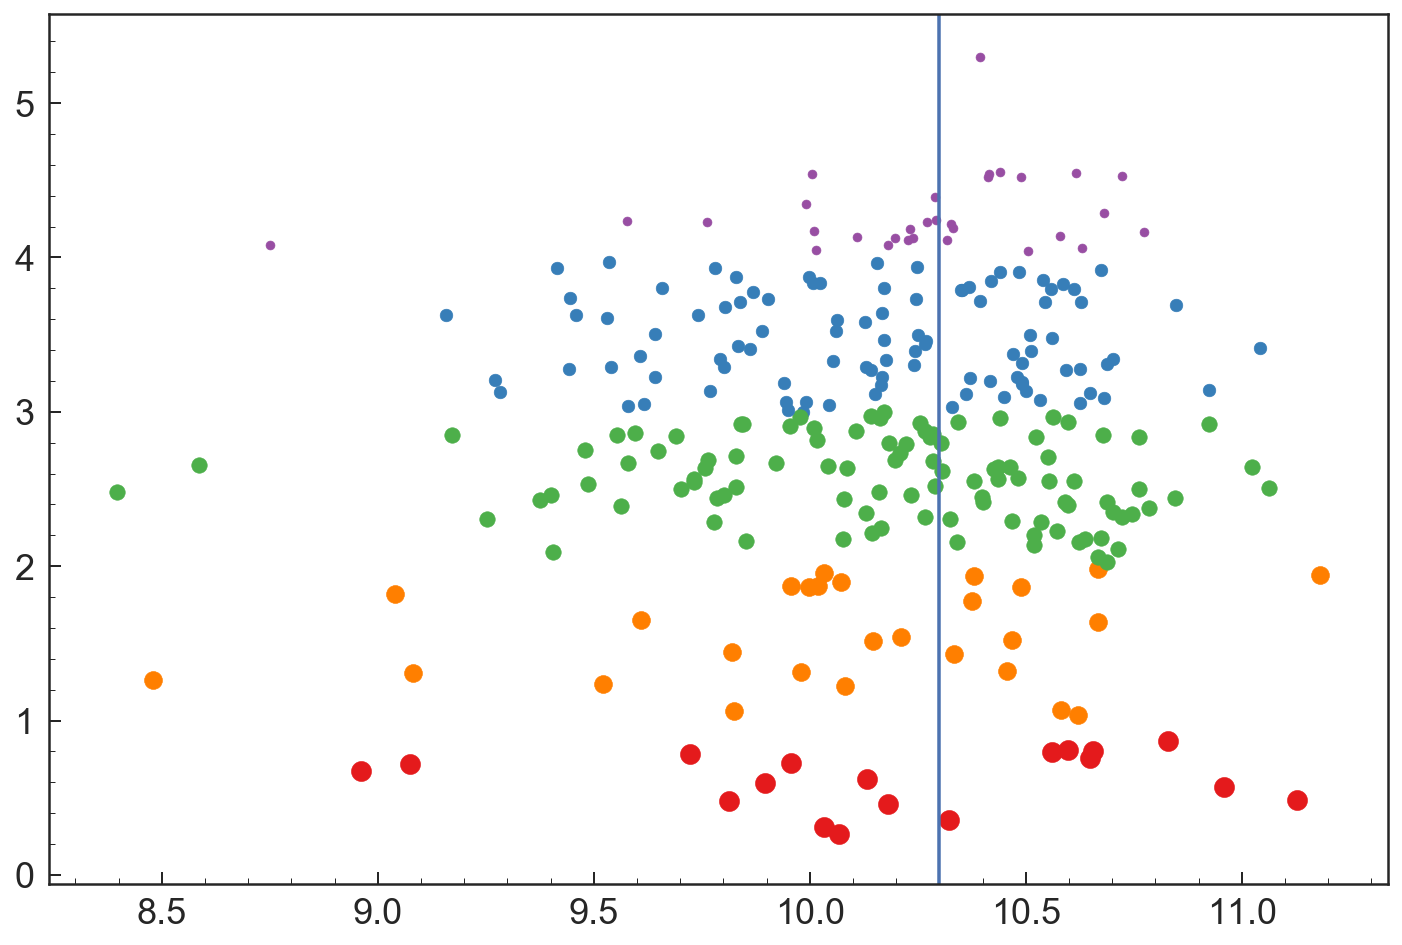

In [211]:
plt.figure(figsize=[12,8])

for i in all_db.index:
    if all_db.zspec[i] != -1:
        rshift = all_db.zspec[i]
    else: 
        rshift = all_db.zphot[i]
    z70 = Oldest_galaxy(rshift)- 10**(all_db.lage[i]-9)
    if z70 > 4:
        c = '#984ea3'
        sz = 20
    if 3 < z70 < 4:
        c = '#377eb8'
        sz = 40
    if 2 < z70 < 3:
        c = '#4daf4a'
        sz = 60
    if 1 < z70 < 2:
        c = '#ff7f00'
        sz = 80
    if 0 < z70 < 1:
        c = '#e41a1c'
        sz = 100
    plt.scatter(np.log10(all_db['Sig1_5'][i]),z70,color=c, s=sz,marker='o')
plt.axvline(10.3)
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.ylim(0,20)
plt.minorticks_on()

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color'
  s)


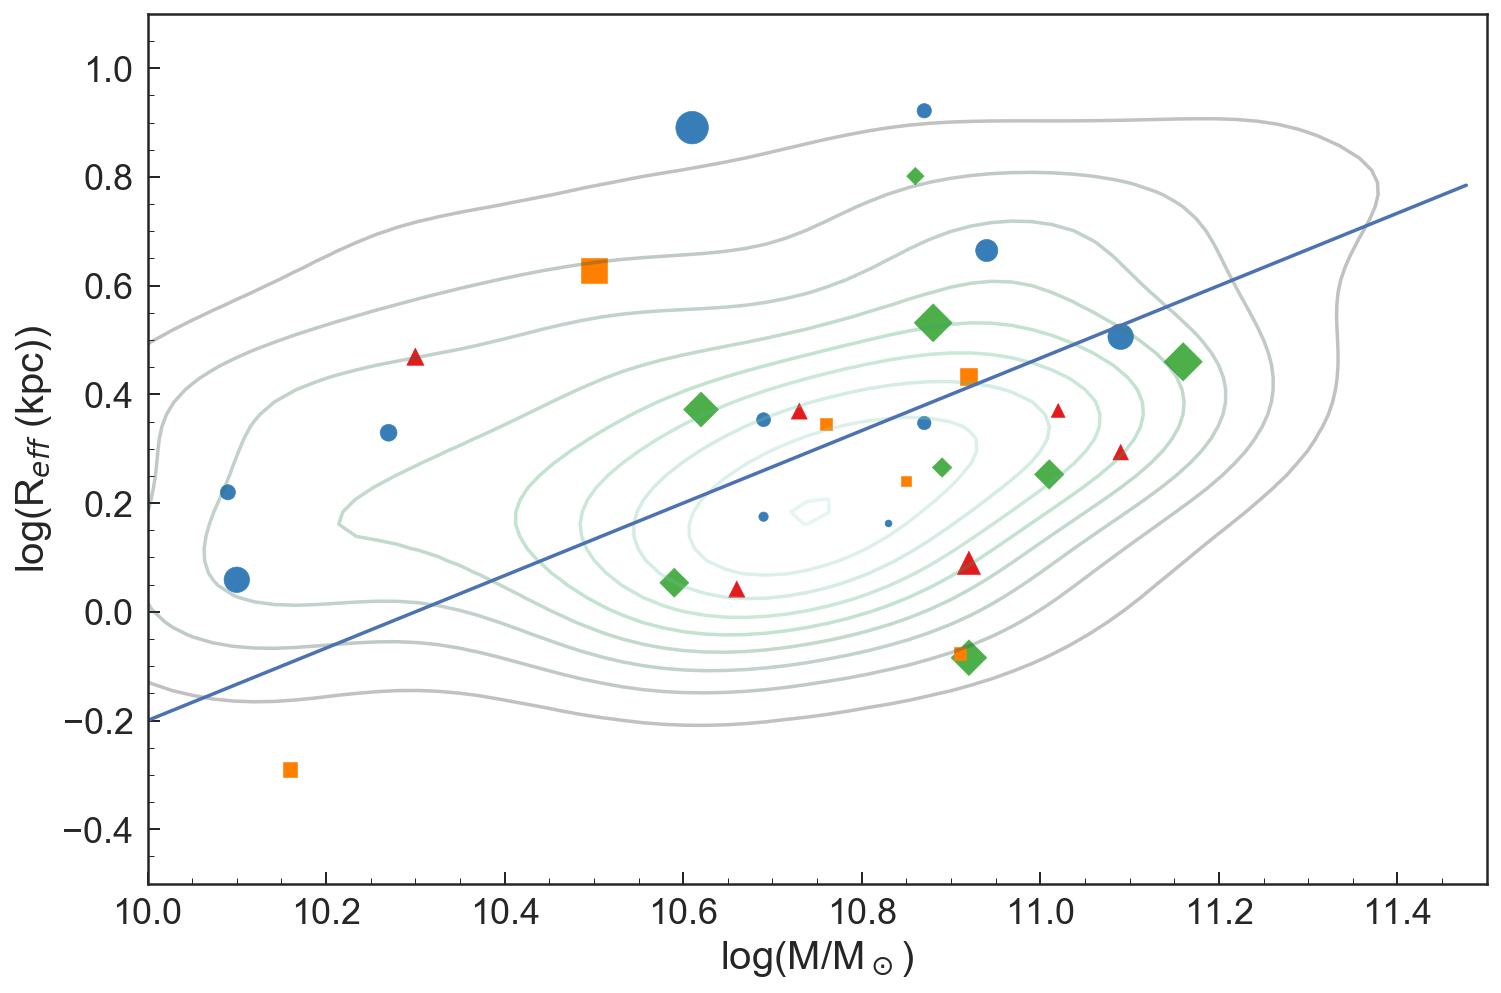

In [276]:
plt.figure(figsize=[12,8])
# plt.scatter(all_db.lmass,np.log10(all_db.reff),color='k', s=10,marker='o')
sea.kdeplot(all_db.lmass,np.log10(all_db.reff),alpha=.3,color='k')
plt.plot(np.log10(np.linspace(1E10,3E11,10000)),np.log10((np.linspace(1E10,3E11,10000)/10**10.3)**(1/1.5)))

sizes = cosmo.kpc_proper_per_arcmin(lzDB['hi_res_specz']) * lzDB['Reff'].values/60 * u.arcmin
plt.scatter(lzDB['lmass'],np.log10(sizes.value),color='#377eb8', 
            s= np.sinh(Oldest_galaxy(lzDB['hi_res_specz'])- lzDB['tx_lwa'])*20,marker='o')

sizes = cosmo.kpc_proper_per_arcmin(mzDB['hi_res_specz']) * mzDB['Reff'].values/60 * u.arcmin
plt.scatter(mzDB['lmass'],np.log10(sizes.value),color='#4daf4a', 
            s= np.sinh(Oldest_galaxy(mzDB['hi_res_specz'])- mzDB['tx_lwa'])*20,marker='D')

sizes = cosmo.kpc_proper_per_arcmin(hzDB['hi_res_specz']) * hzDB['Reff'].values/60 * u.arcmin
plt.scatter(hzDB['lmass'],np.log10(sizes.value),color='#ff7f00', 
           s= np.sinh(Oldest_galaxy(hzDB['hi_res_specz'])- hzDB['tx_lwa'])*20,marker='s')

sizes = cosmo.kpc_proper_per_arcmin(uhzDB['hi_res_specz']) * uhzDB['Reff'].values/60 * u.arcmin
plt.scatter(uhzDB['lmass'],np.log10(sizes.value),color='#e41a1c', 
            s= np.sinh(Oldest_galaxy(uhzDB['hi_res_specz'])- uhzDB['tx_lwa'])*20,marker='^')

plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('log(M/M$_\odot$)',fontsize=20)
plt.ylabel('log(R$_{eff}$ (kpc))',fontsize=20)
plt.xlim(10,11.5)
plt.ylim(-.5,1.1)
plt.minorticks_on()
plt.savefig('../plots/reff_lmass.png',bbox_inches = 'tight')



/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color'
  s)


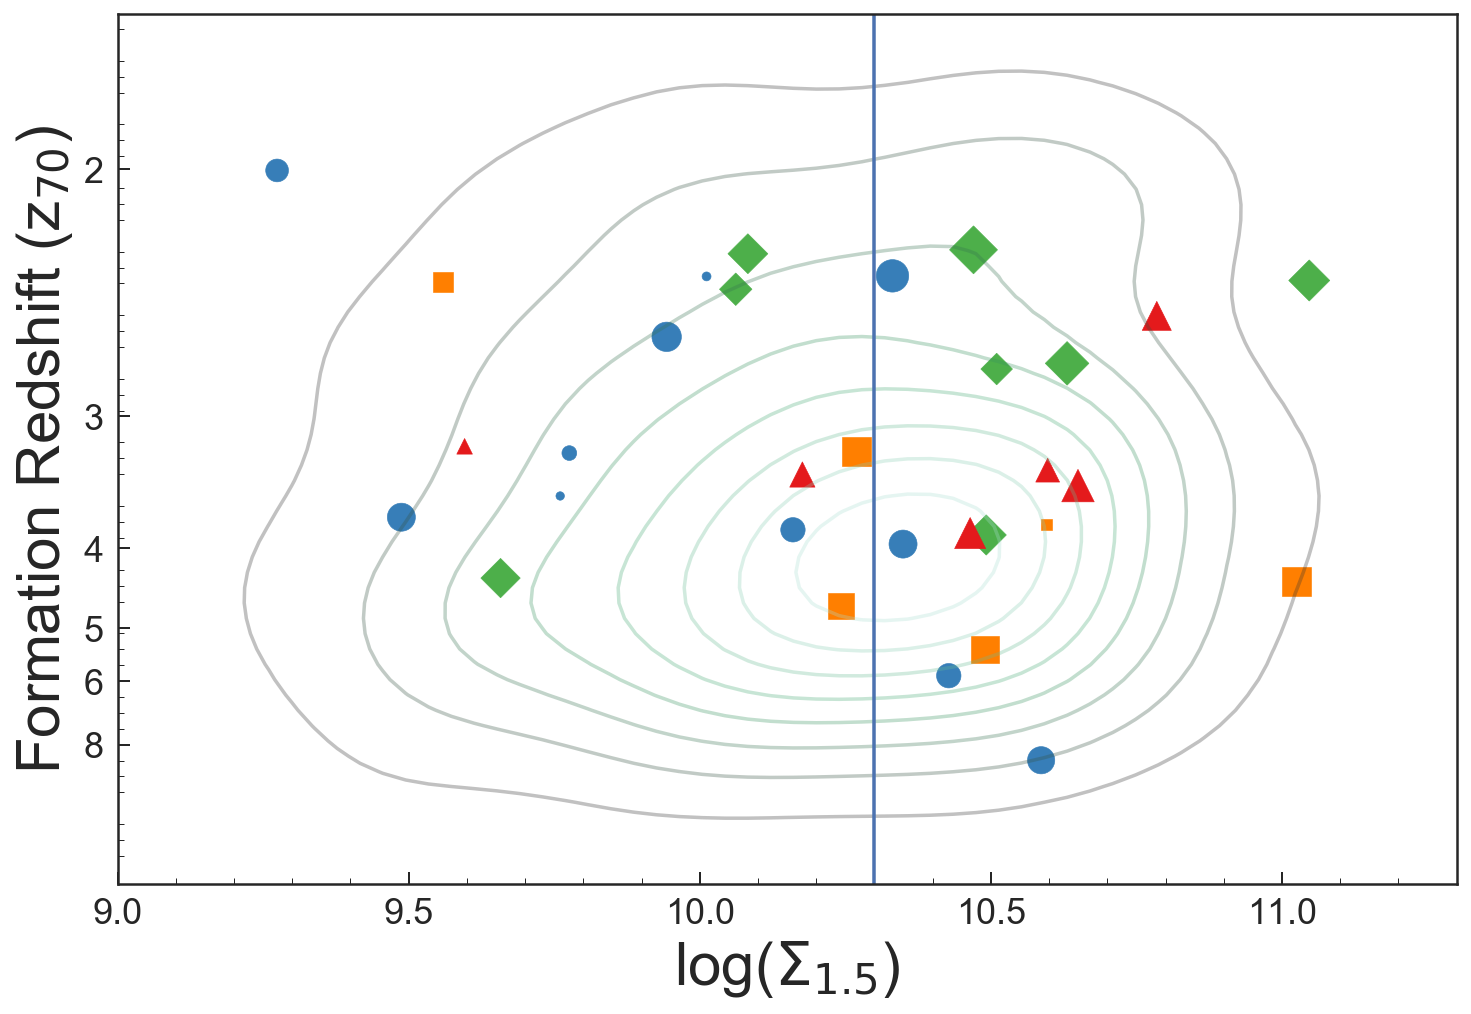

In [277]:
plt.figure(figsize=[12,8])
sea.kdeplot(np.log10(all_db.Sig1_5),10**(all_db.lage-9),alpha=.3,color='k')
plt.axvline(10.3)
sizes = cosmo.kpc_proper_per_arcmin(lzDB['hi_res_specz']) * lzDB['Reff'].values/60 * u.arcmin
plt.scatter(np.log10(10**lzDB['lmass']/sizes.value**1.5),Oldest_galaxy(lzDB['hi_res_specz'])- lzDB['tx_lwa'],color='#377eb8', 
            s= np.sinh(lzDB.lmass-10)*200,marker='o')

sizes = cosmo.kpc_proper_per_arcmin(mzDB['hi_res_specz']) * mzDB['Reff'].values/60 * u.arcmin
plt.scatter(np.log10(10**mzDB['lmass']/sizes.value**1.5),Oldest_galaxy(mzDB['hi_res_specz'])- mzDB['tx_lwa'],color='#4daf4a', 
            s= np.sinh(mzDB.lmass-10)*200,marker='D')

sizes = cosmo.kpc_proper_per_arcmin(hzDB['hi_res_specz']) * hzDB['Reff'].values/60 * u.arcmin
plt.scatter(np.log10(10**hzDB['lmass']/sizes.value**1.5),Oldest_galaxy(hzDB['hi_res_specz'])- hzDB['tx_lwa'],color='#ff7f00', 
            s= np.sinh(hzDB.lmass-10)*200,marker='s')

sizes = cosmo.kpc_proper_per_arcmin(uhzDB['hi_res_specz']) * uhzDB['Reff'].values/60 * u.arcmin
plt.scatter(np.log10(10**uhzDB['lmass']/sizes.value**1.5),Oldest_galaxy(uhzDB['hi_res_specz'])- uhzDB['tx_lwa'],color='#e41a1c', 
            s= np.sinh(uhzDB.lmass-10)*200,marker='^')

plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('log($\Sigma _{1.5}$)',fontsize=30)
plt.ylabel('Formation Redshift (z$_{70}$)',size=30)
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])
plt.xlim(9,11.3)
plt.ylim(0,4)
plt.minorticks_on()
plt.savefig('../plots/z70_sig.png',bbox_inches = 'tight')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


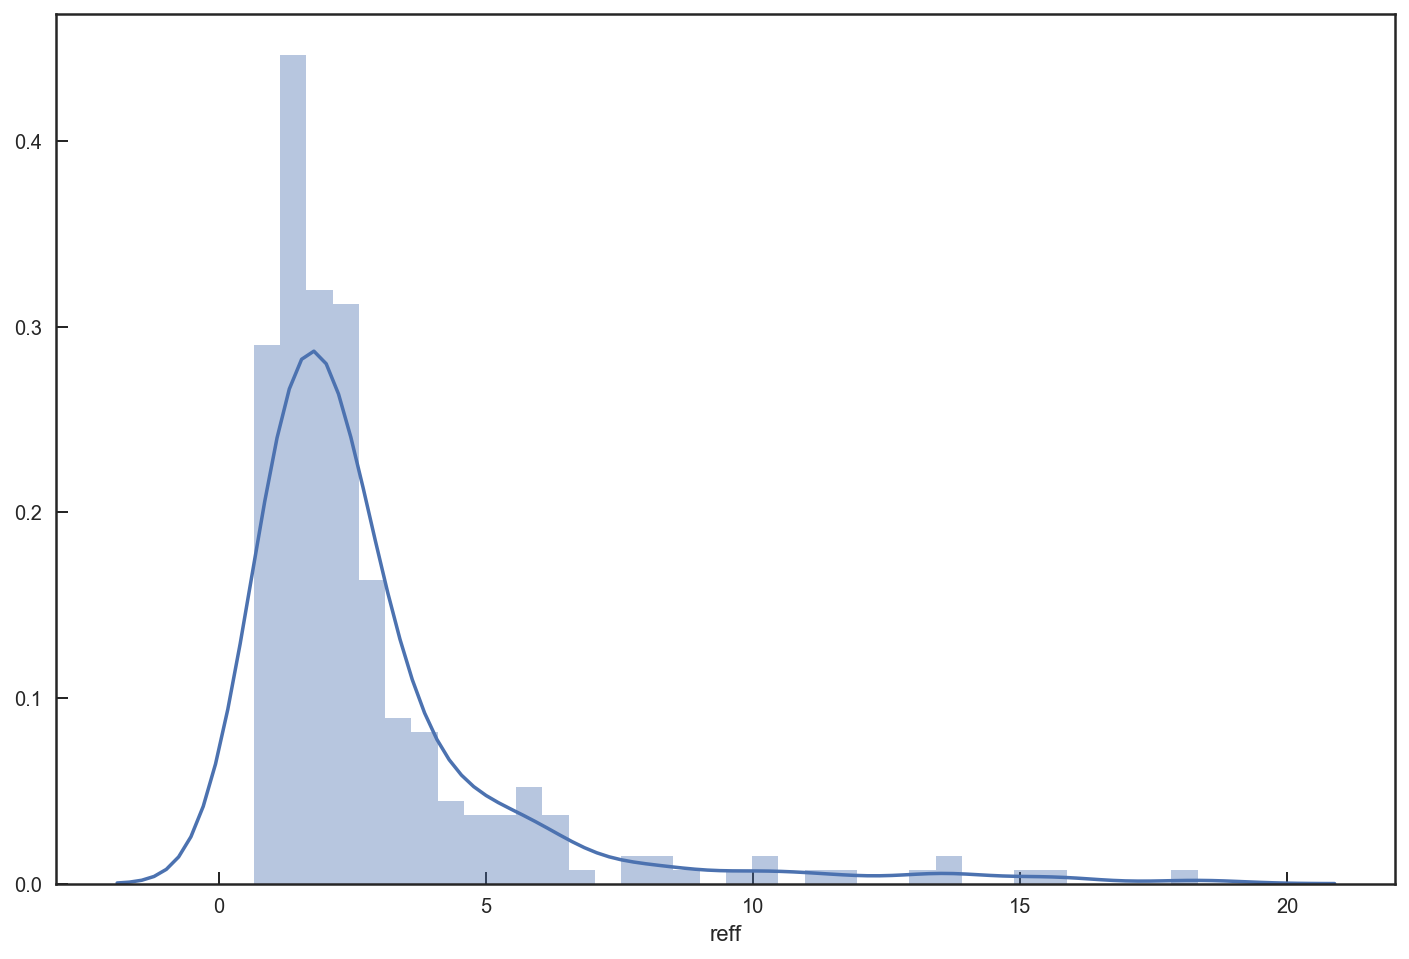

In [153]:
plt.figure(figsize=[12,8])
sea.distplot(all_db.reff)